In [1]:
#import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
from prettytable import PrettyTable
import keras

In [2]:
#import project libs
from PowerAIDataHandler.PowerAIDataHandler import ClassPowerAIDataHandler

In [3]:
#init datahandler using configuration from .env
dh = ClassPowerAIDataHandler("C:/Users/Kids/iCloudDrive/Documents/GitHub/PowerAI/.env")

#init parameters for neural network
num_devices   = len(dh.device_list)   #länge der Gerätliste
event_ratio   = 0.5 #Verhältnis Trainings-/Testdaten
window_length = 43 #maximale Anzahl an Daten die gleichzeitig eingespeist werden
epochs        = 400 #Anzahl der Traings-/Testdurchläufe

C:\Users\Kids\iCloudDrive\Documents\GitHub\PowerAI\PowerAIDataHandler\PowerAIDataHandler.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()


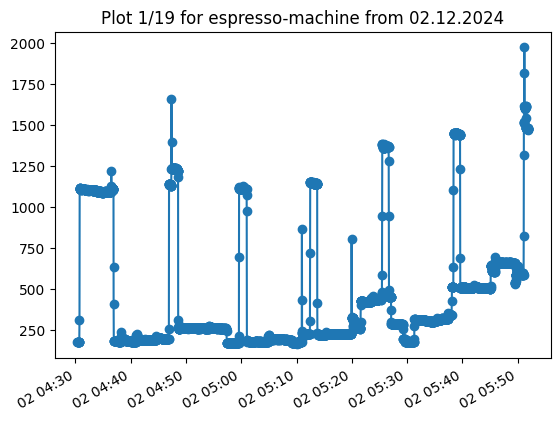

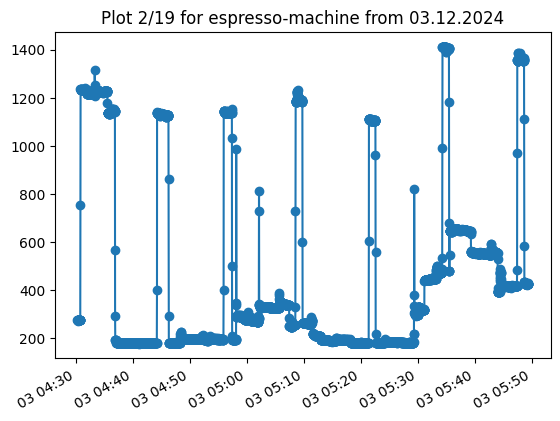

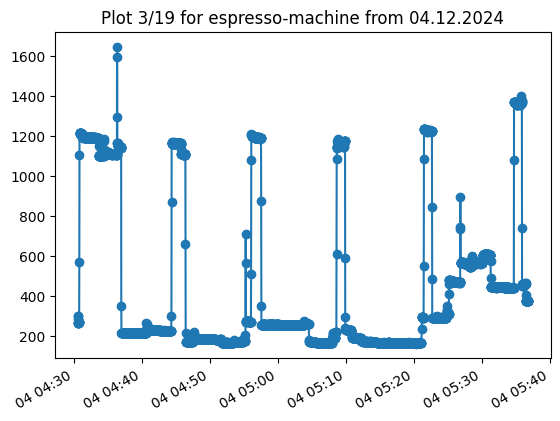

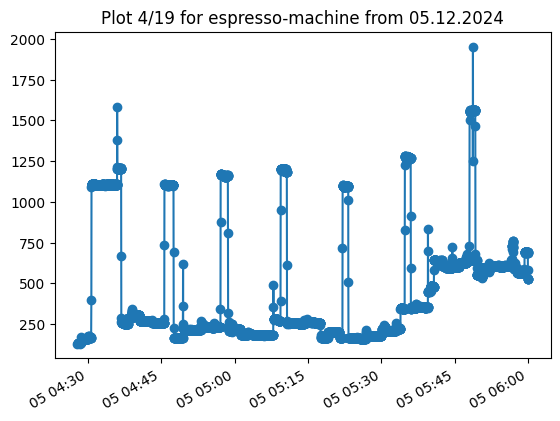

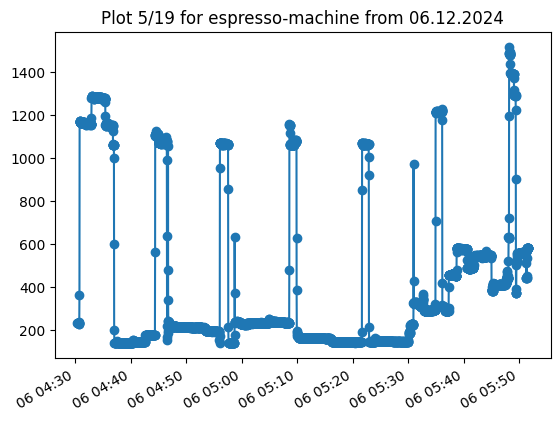

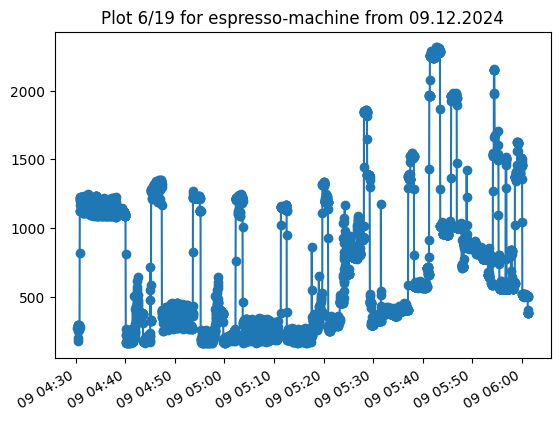

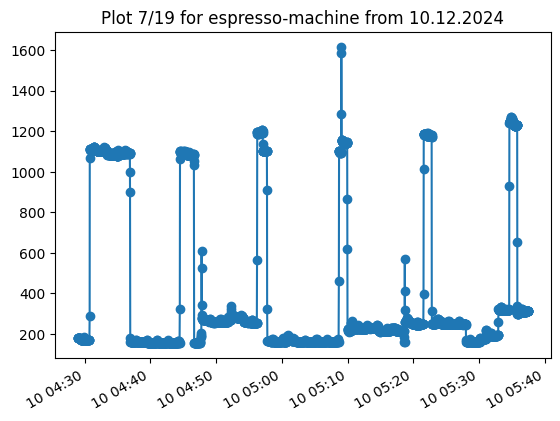

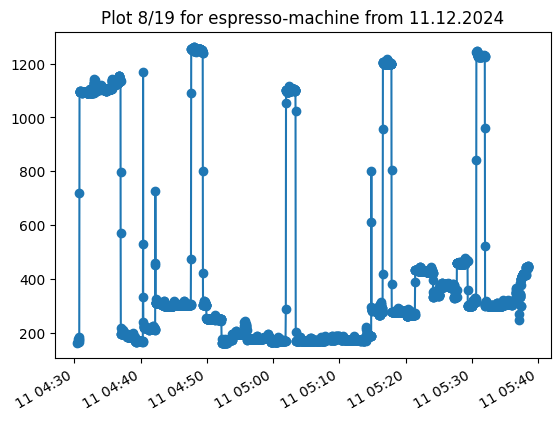

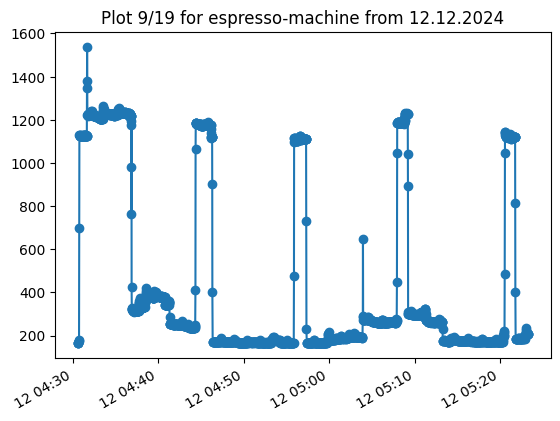

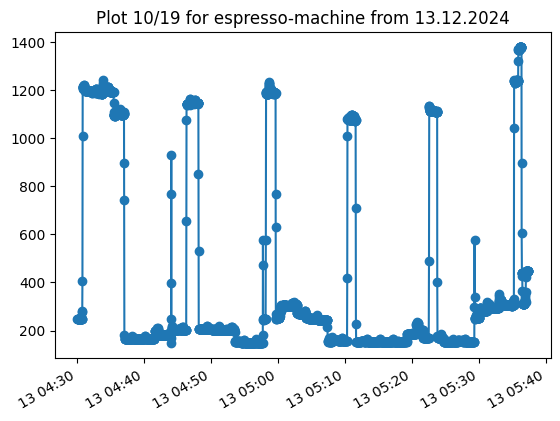

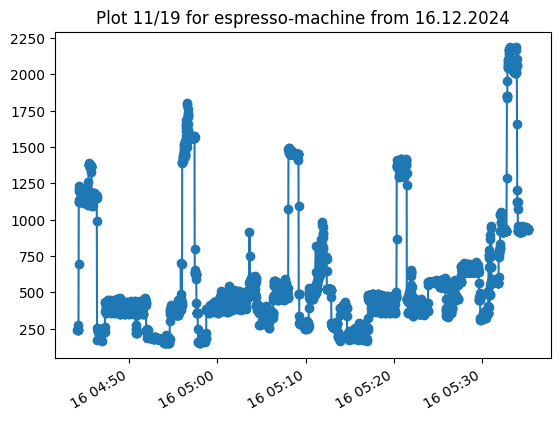

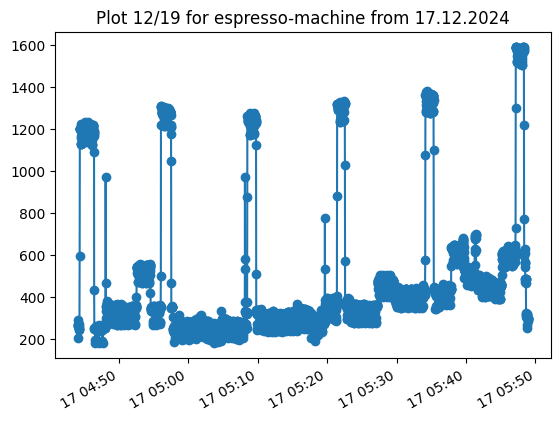

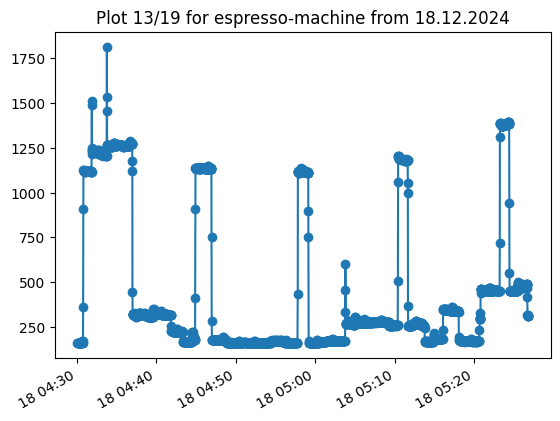

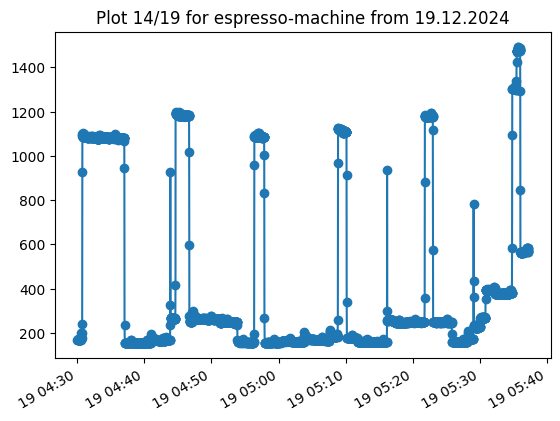

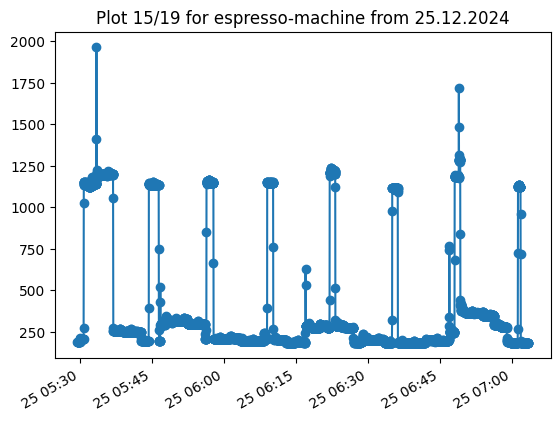

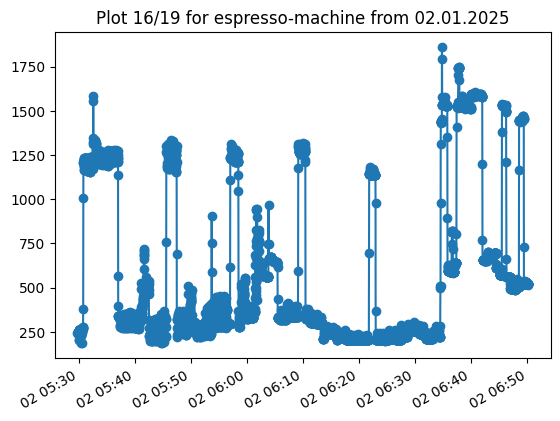

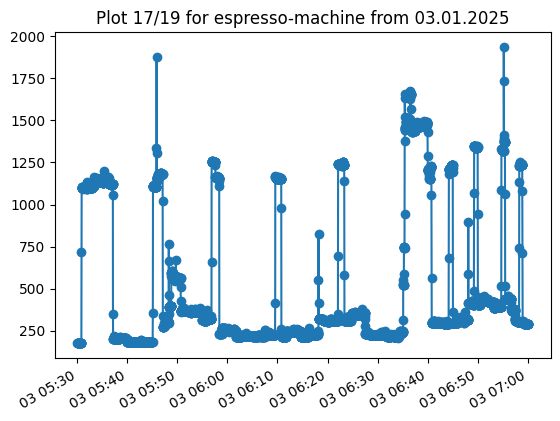

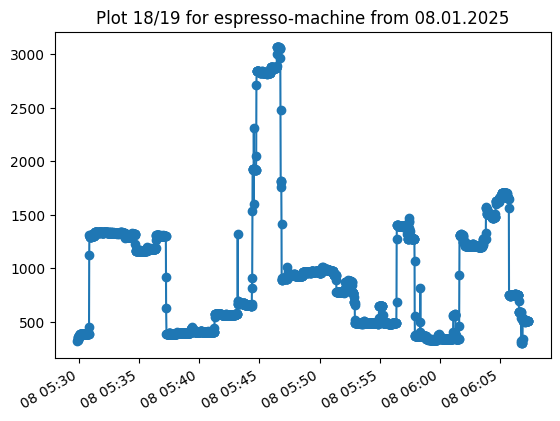

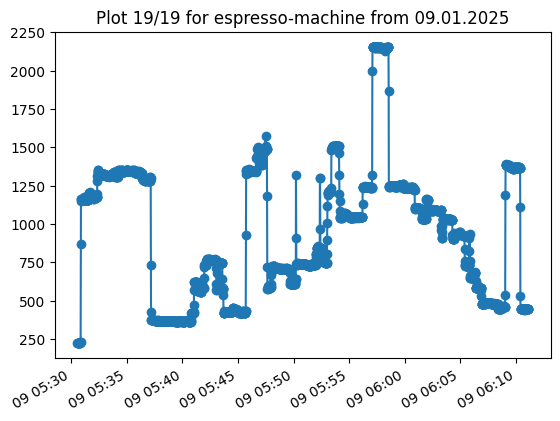

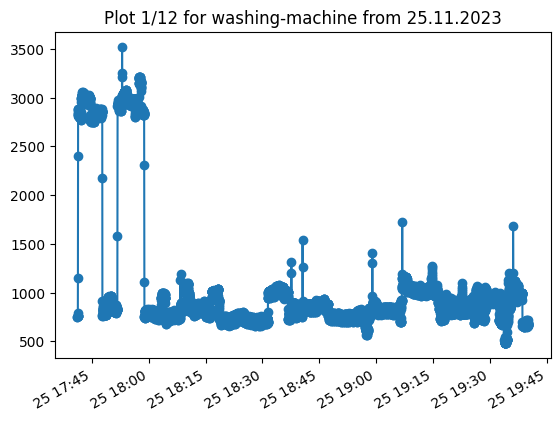

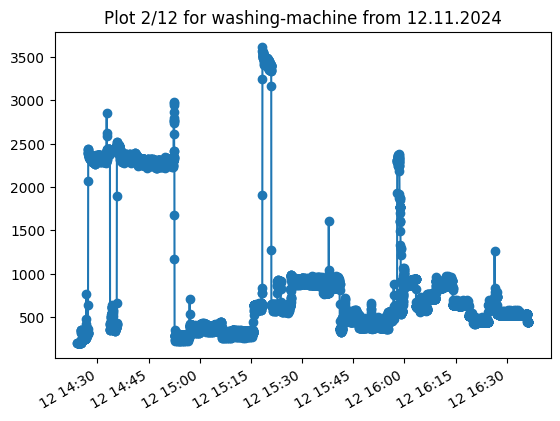

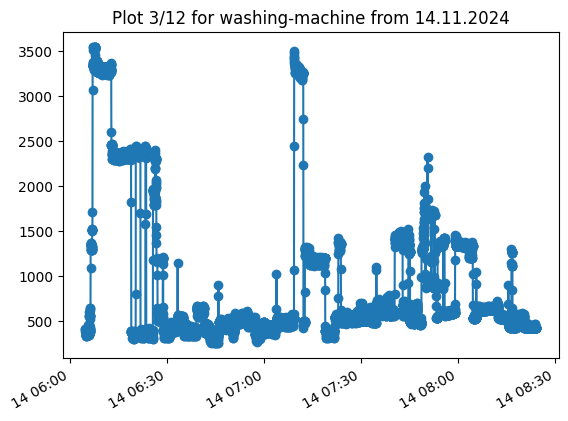

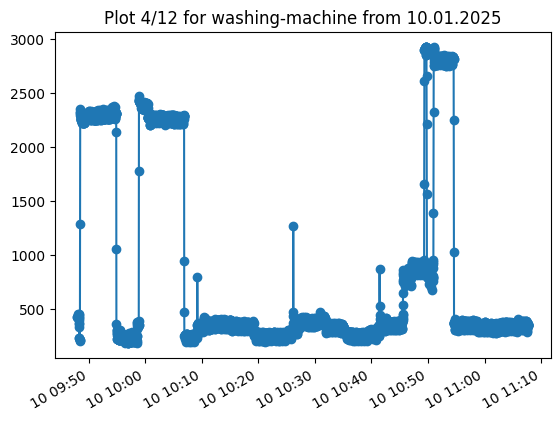

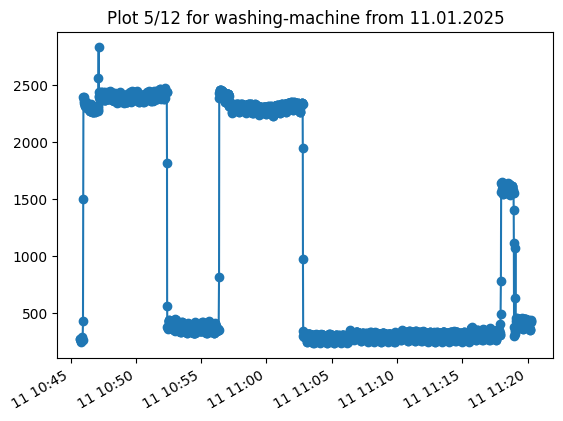

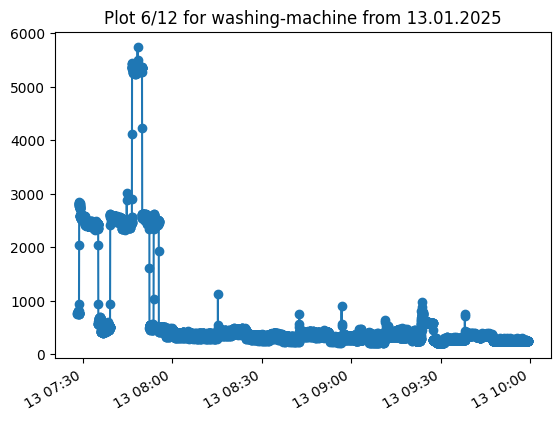

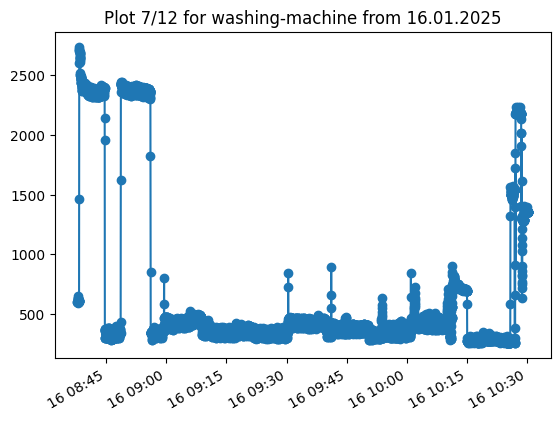

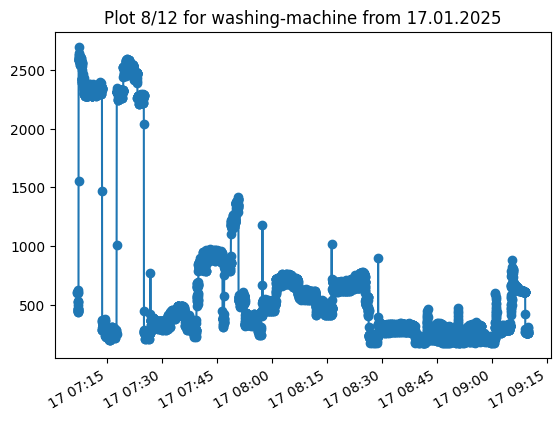

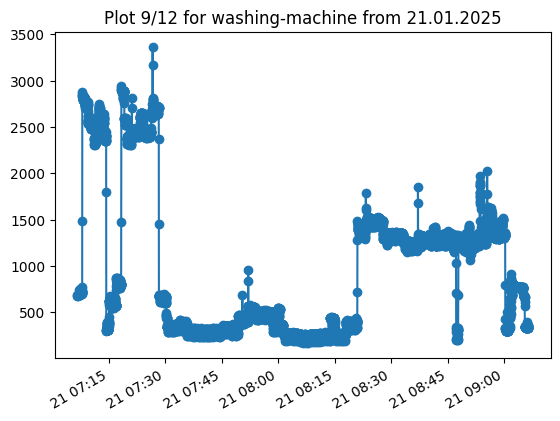

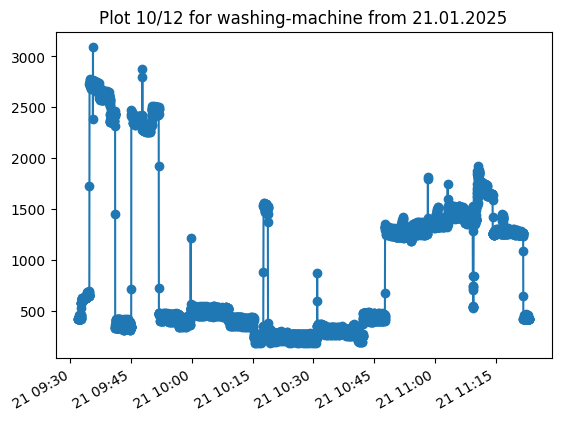

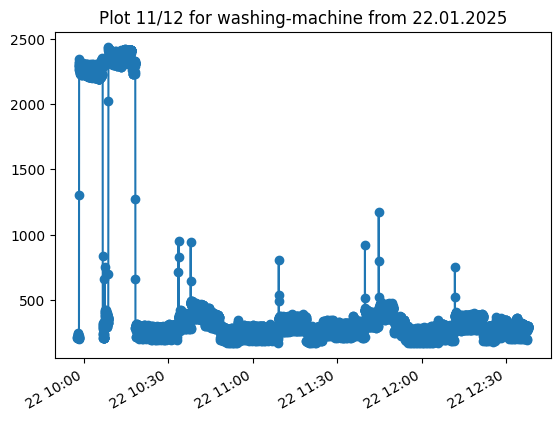

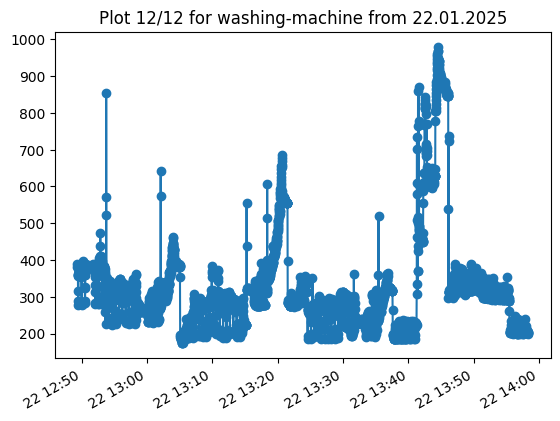

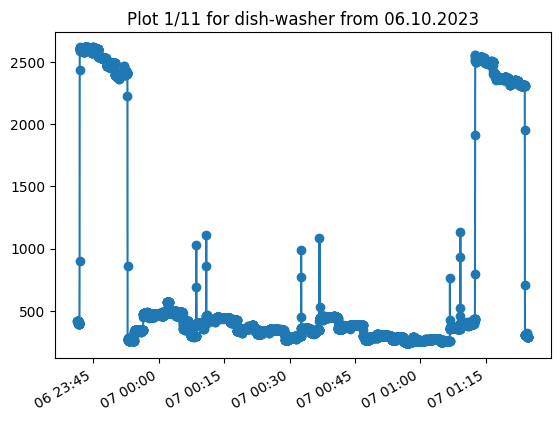

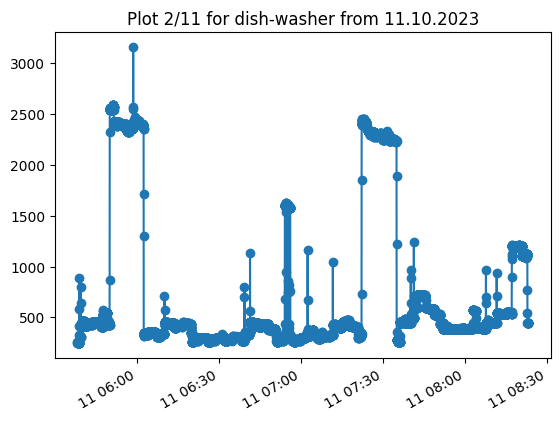

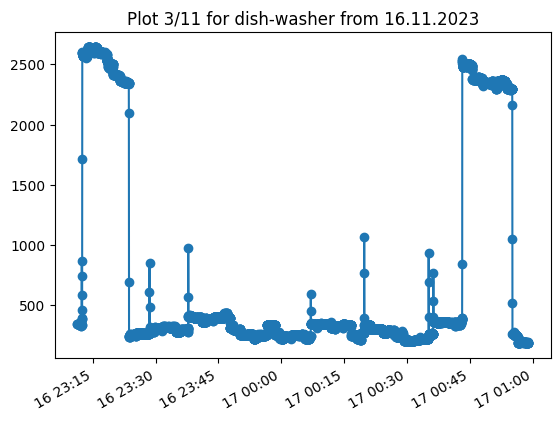

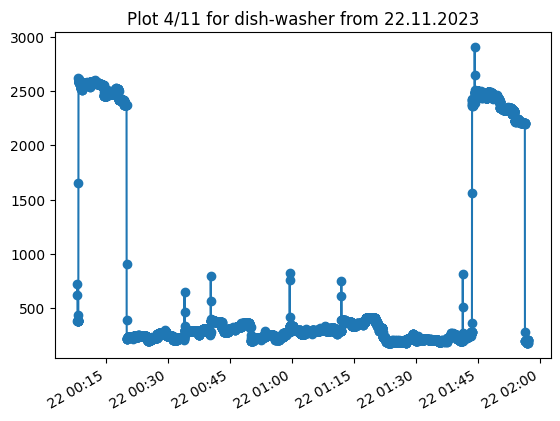

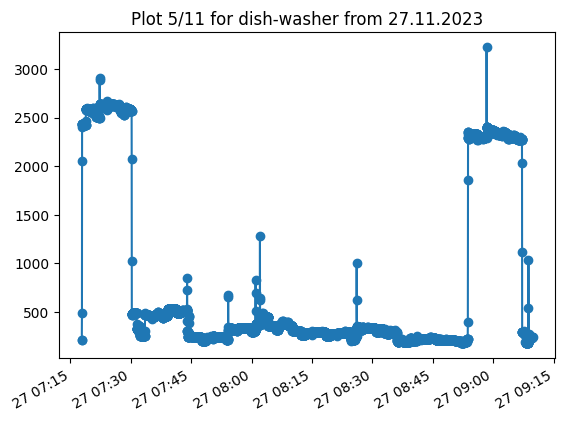

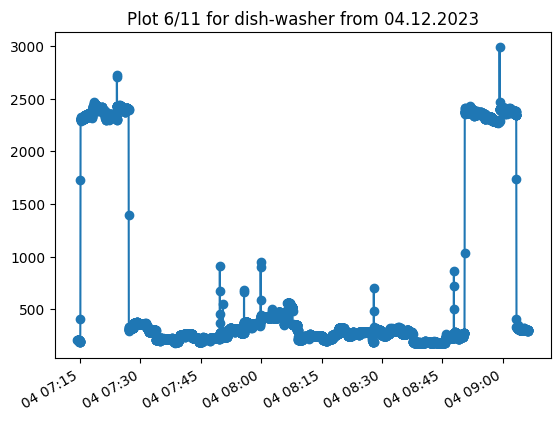

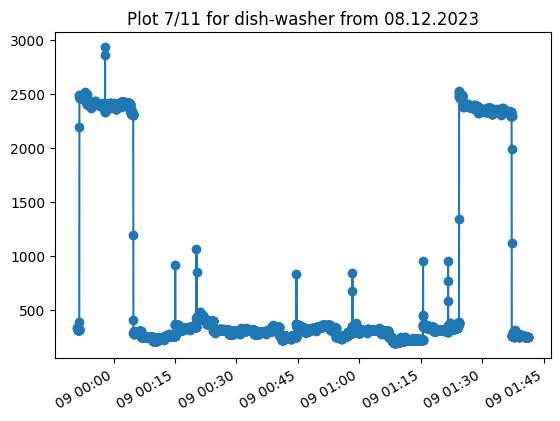

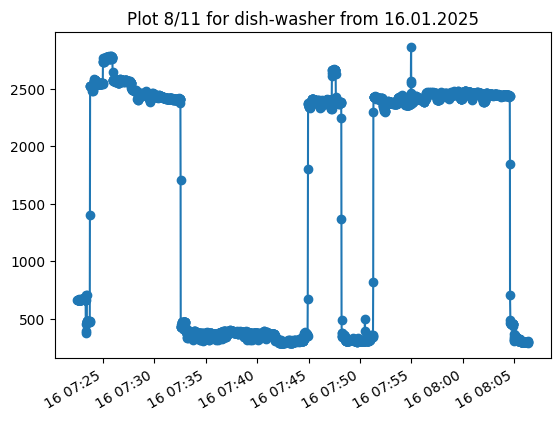

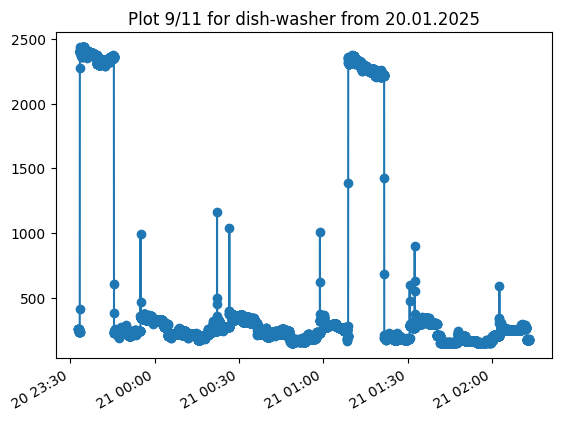

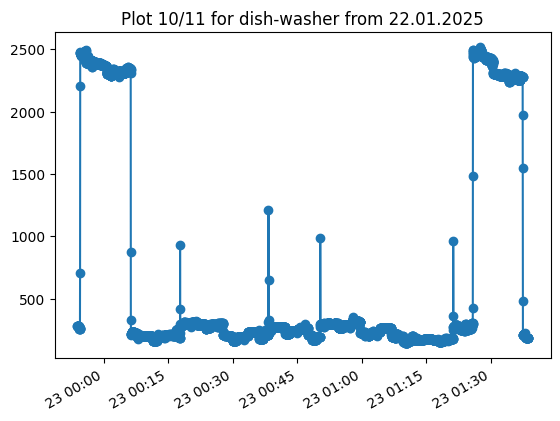

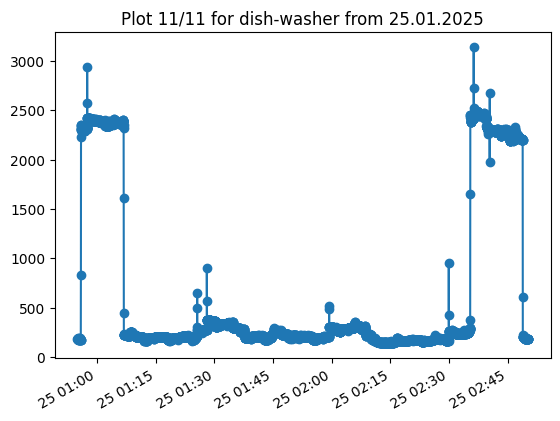

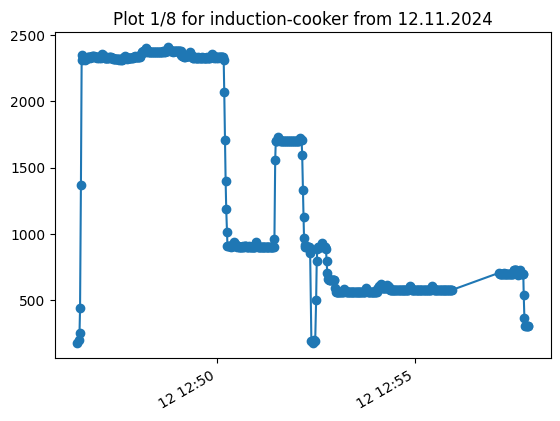

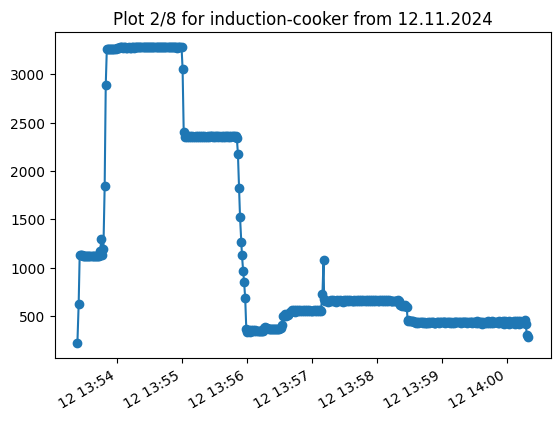

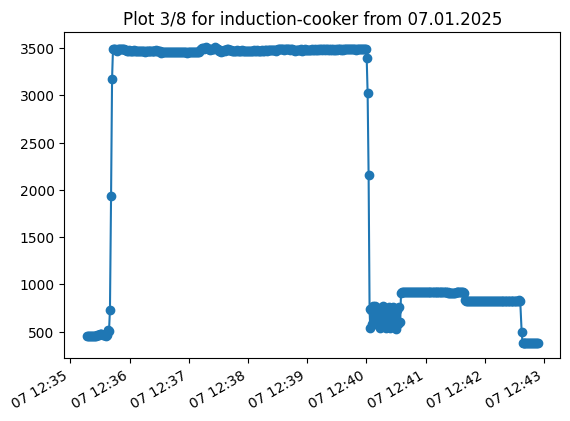

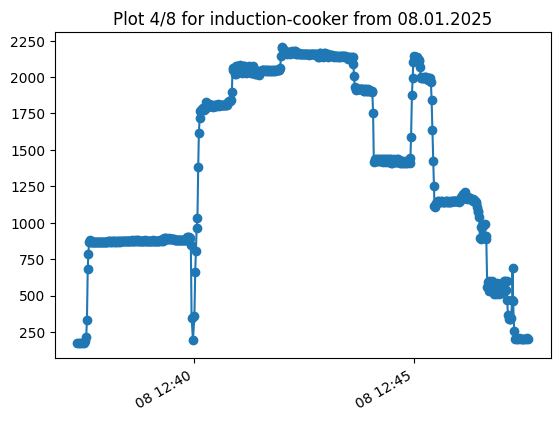

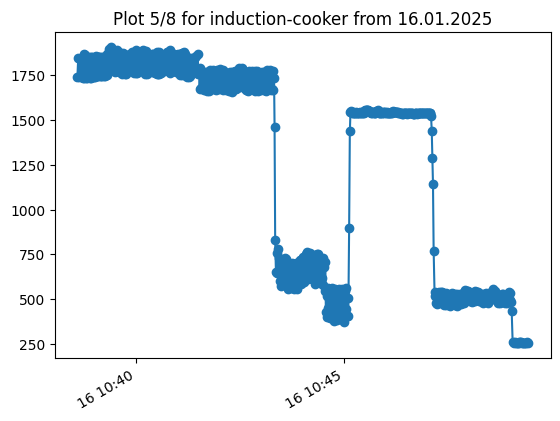

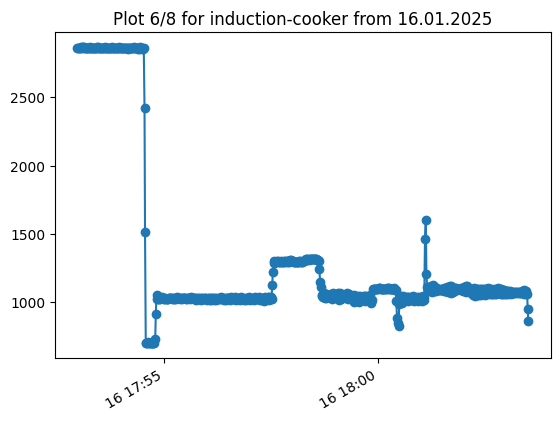

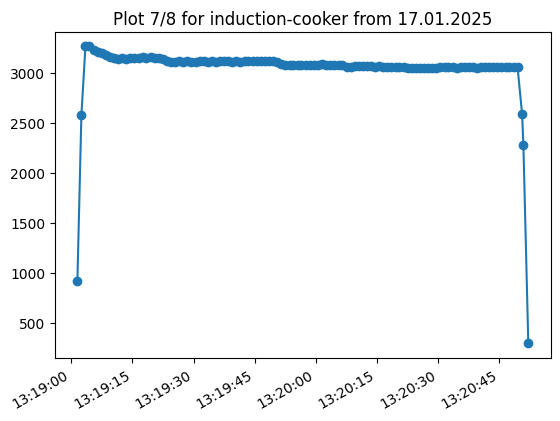

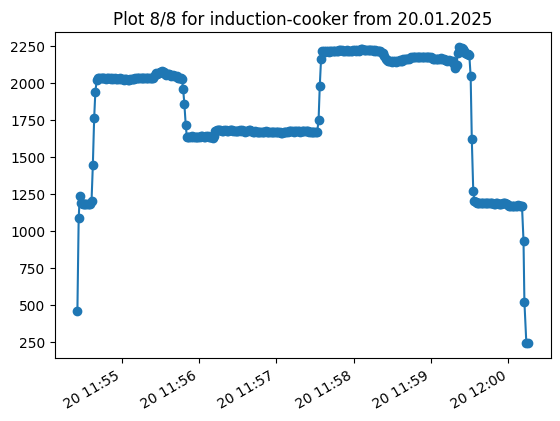

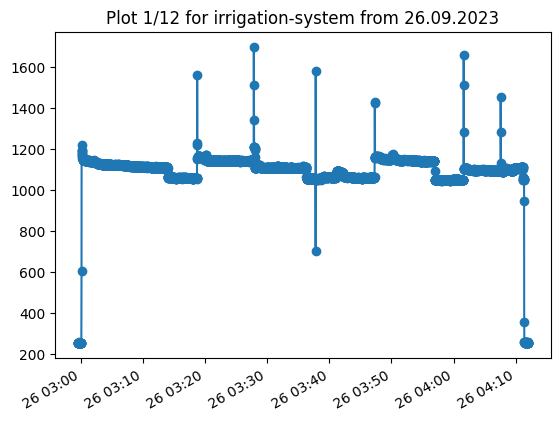

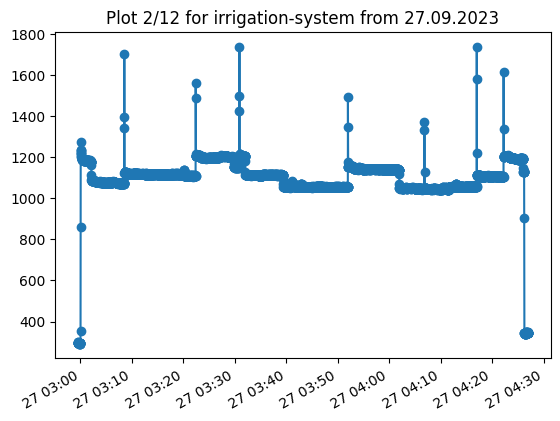

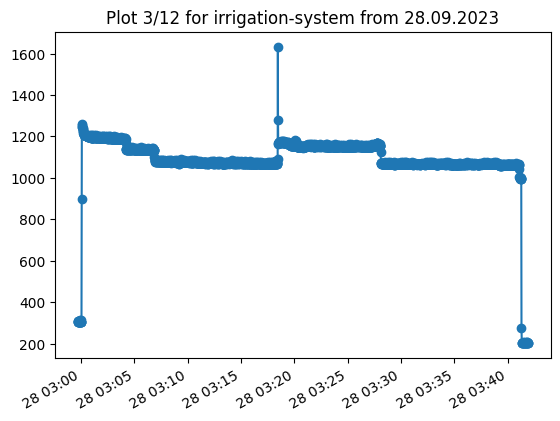

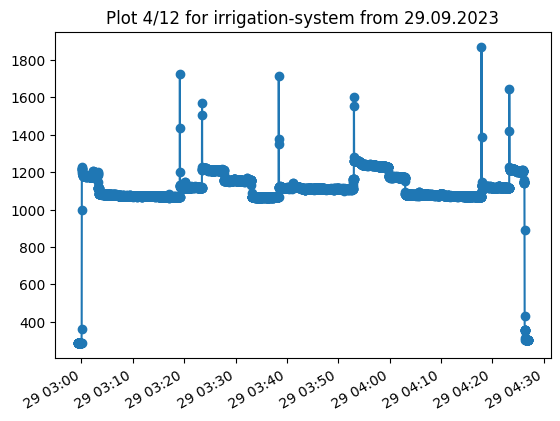

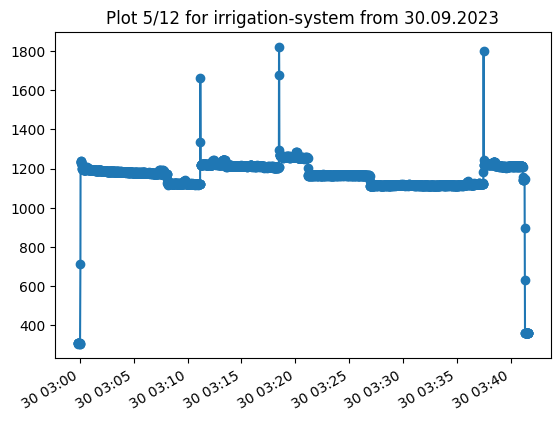

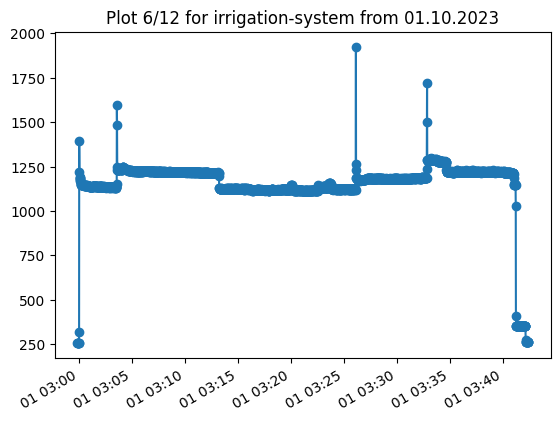

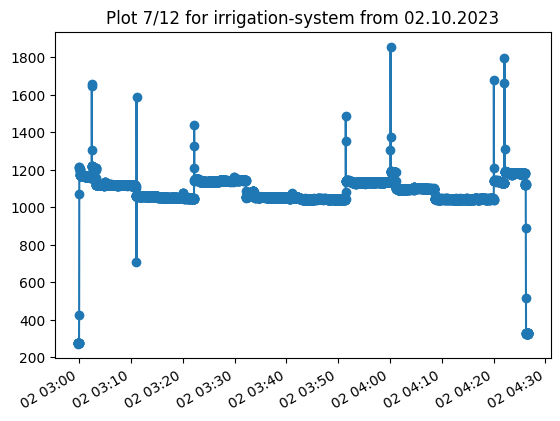

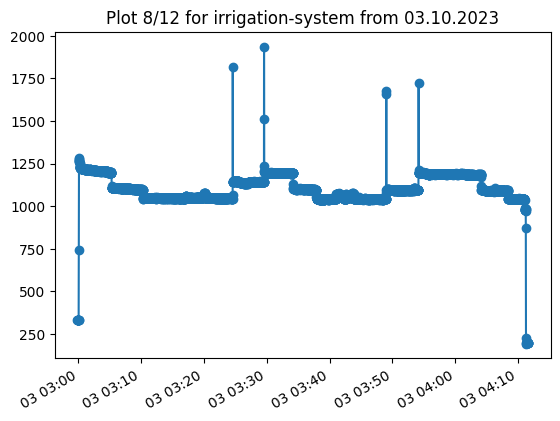

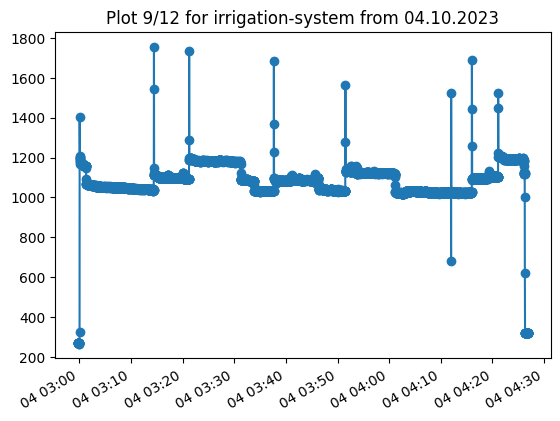

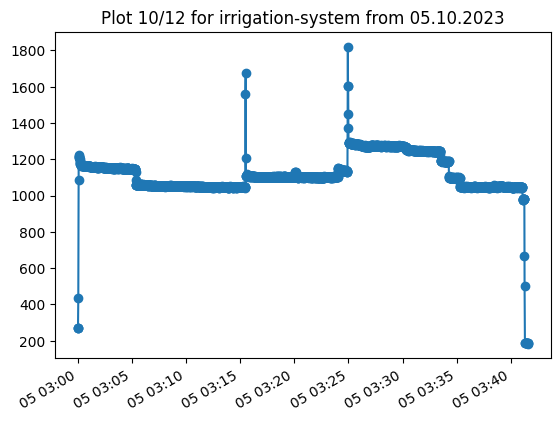

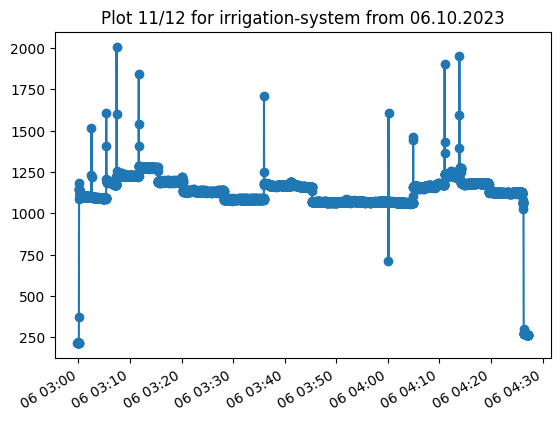

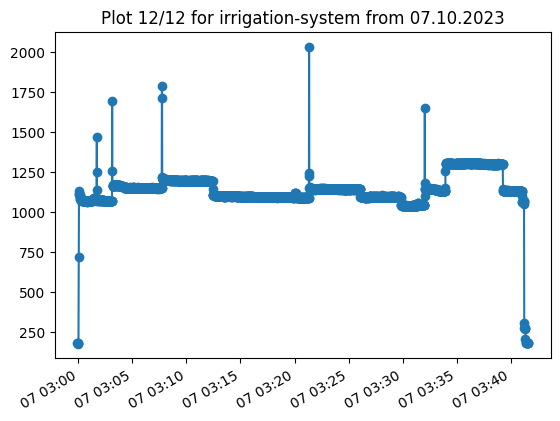

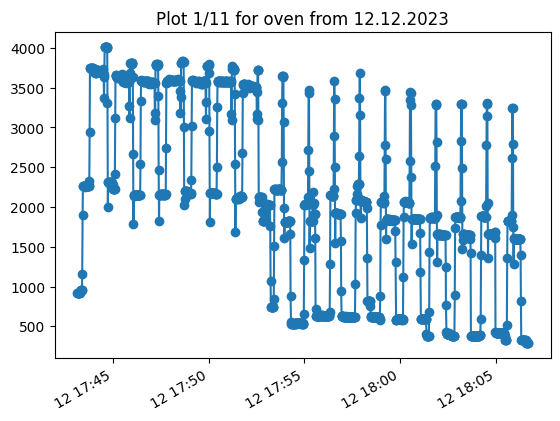

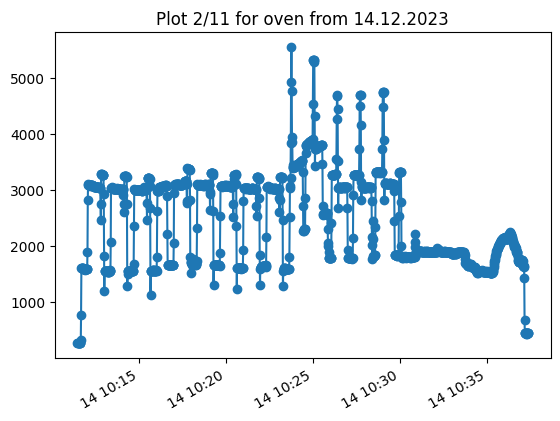

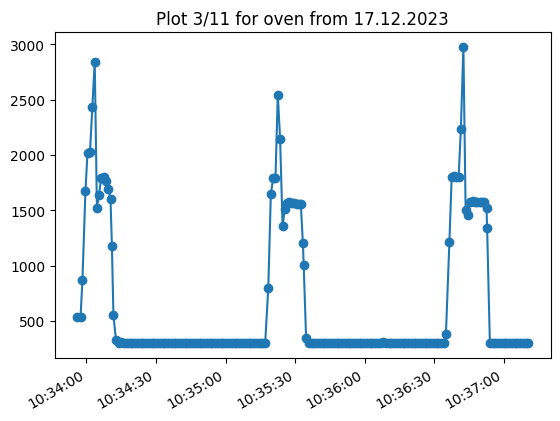

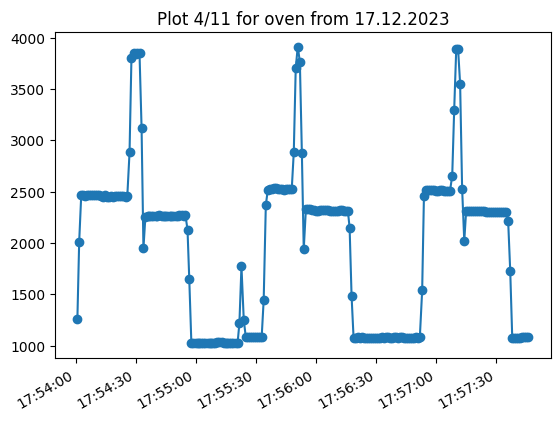

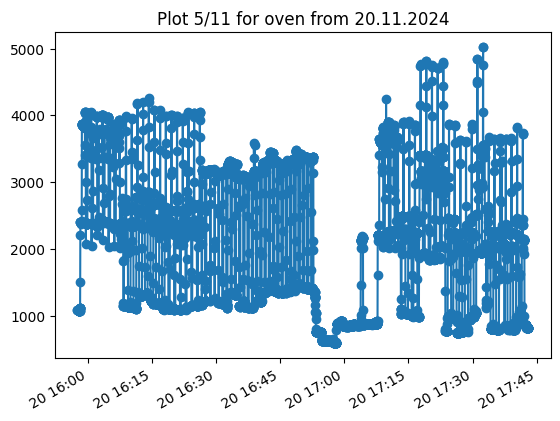

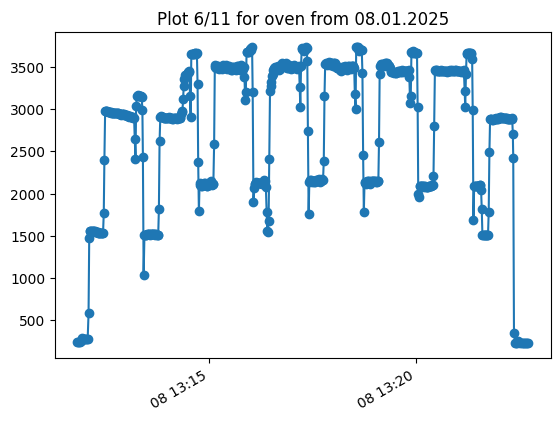

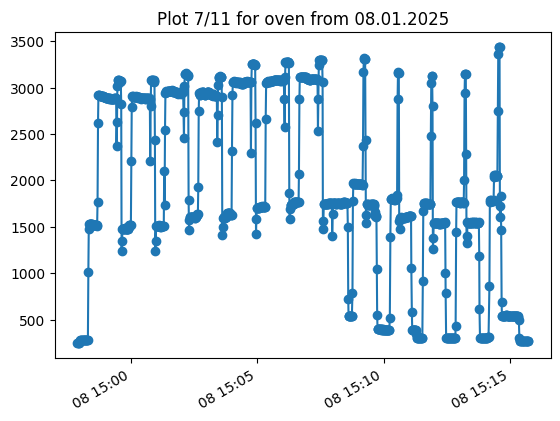

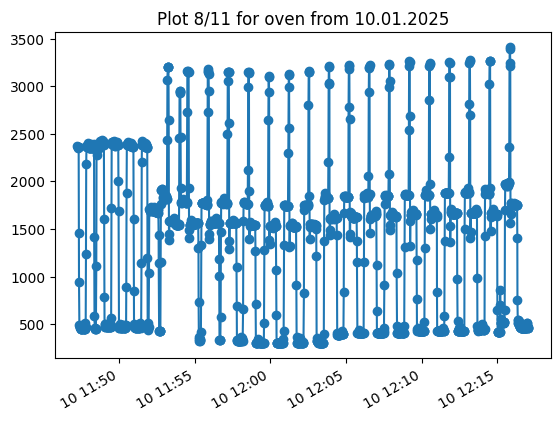

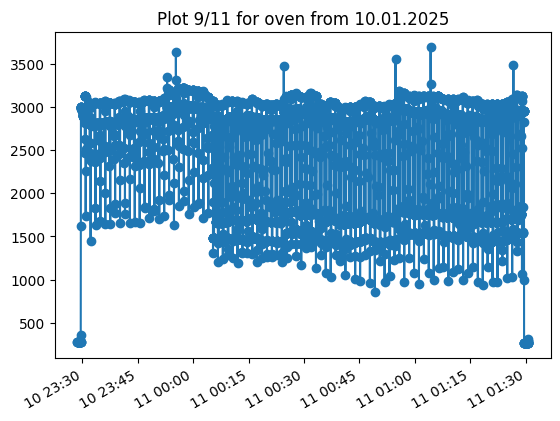

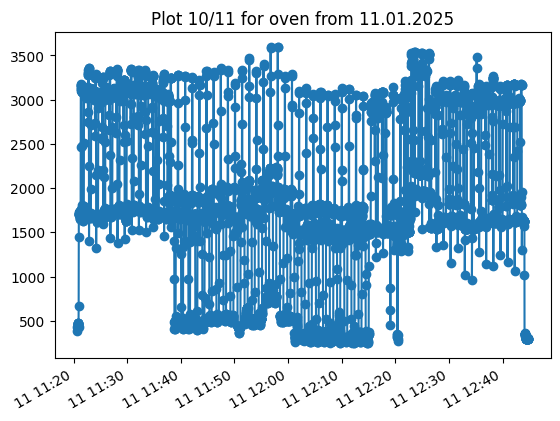

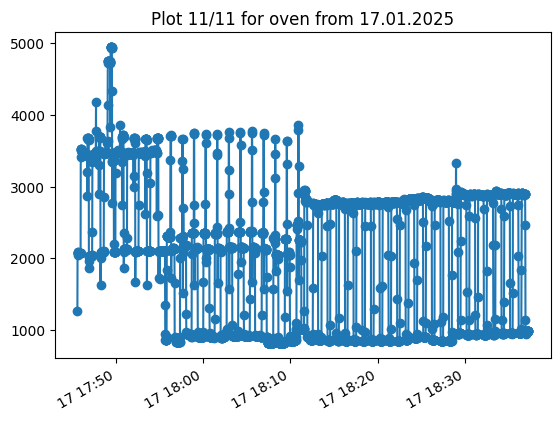

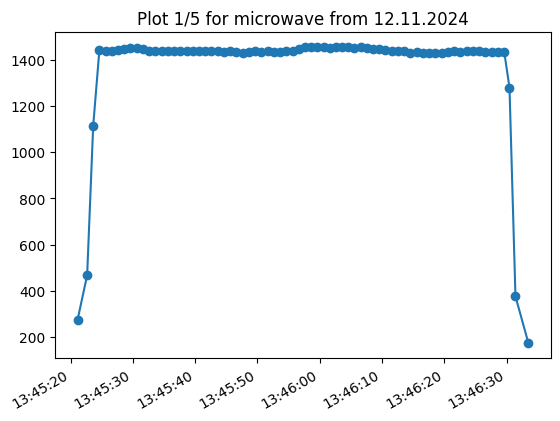

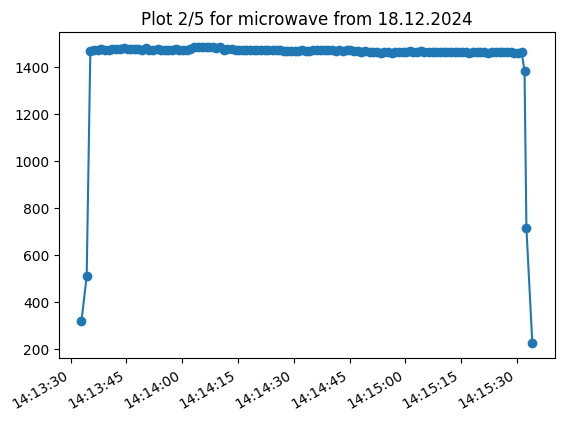

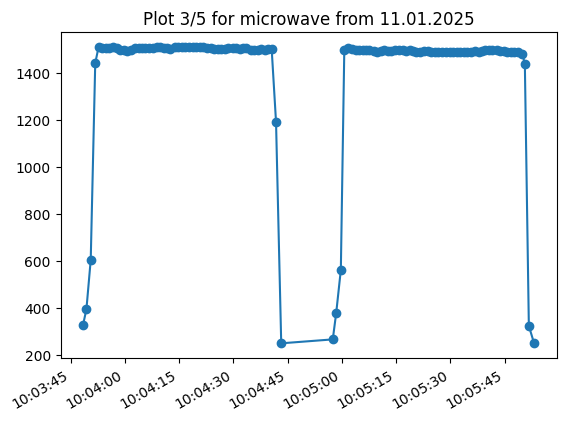

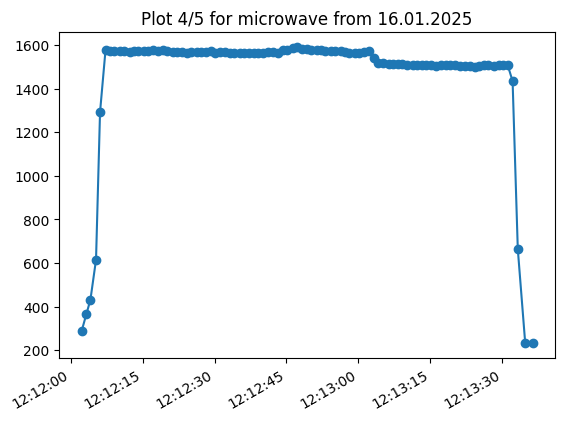

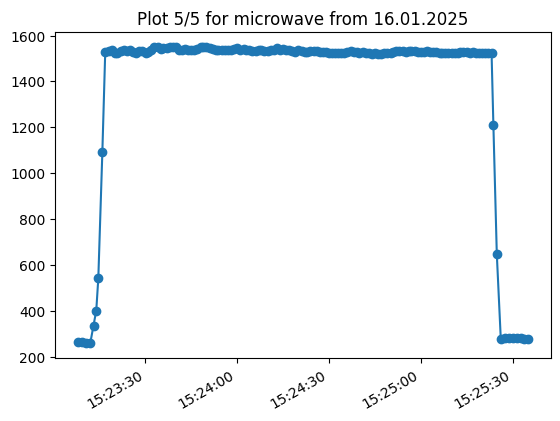

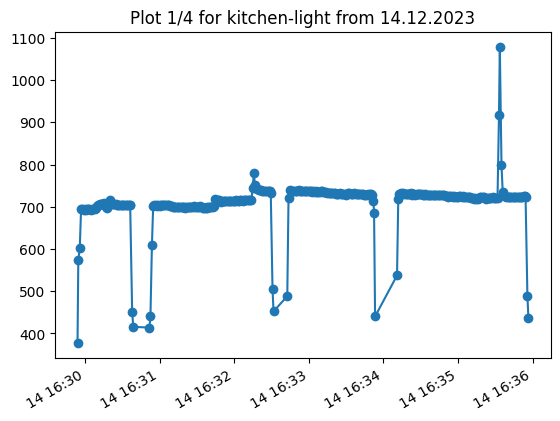

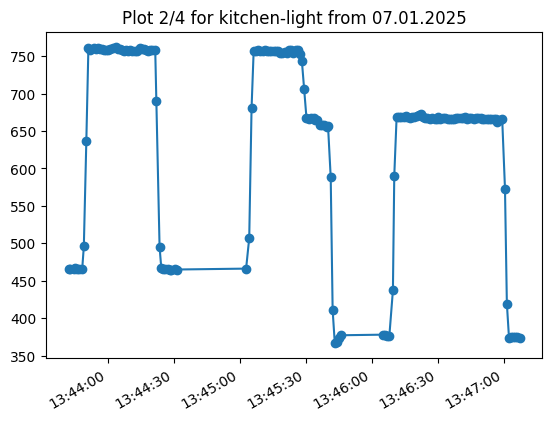

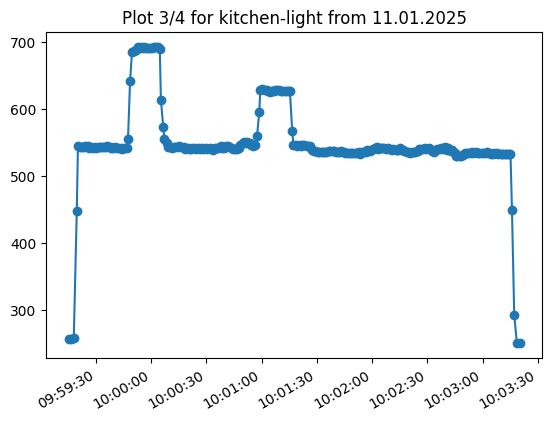

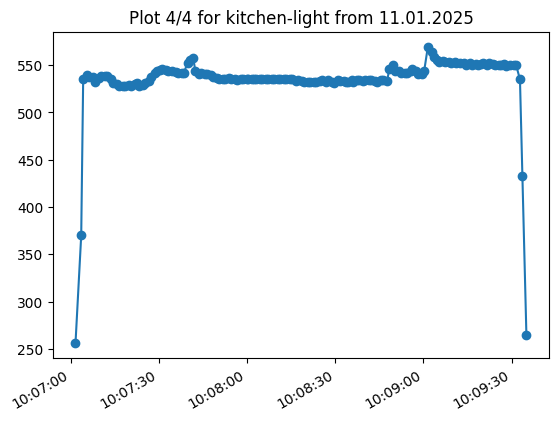

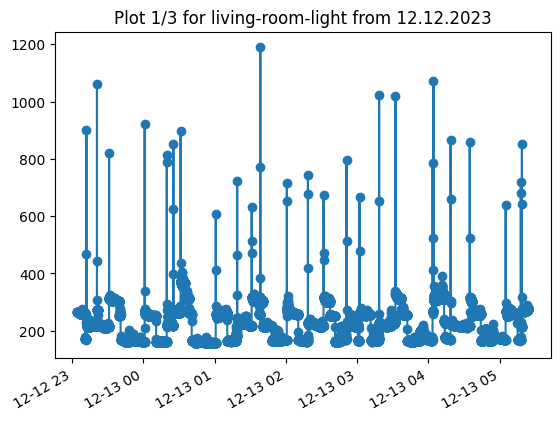

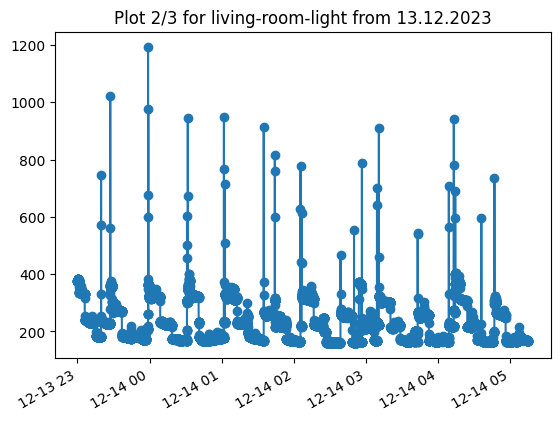

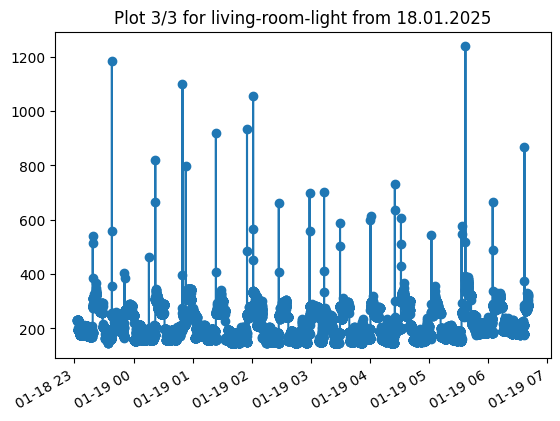

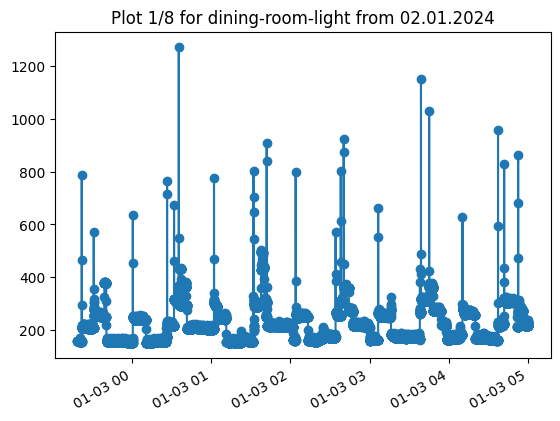

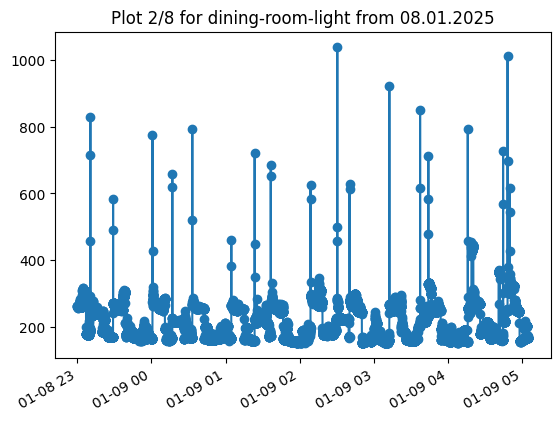

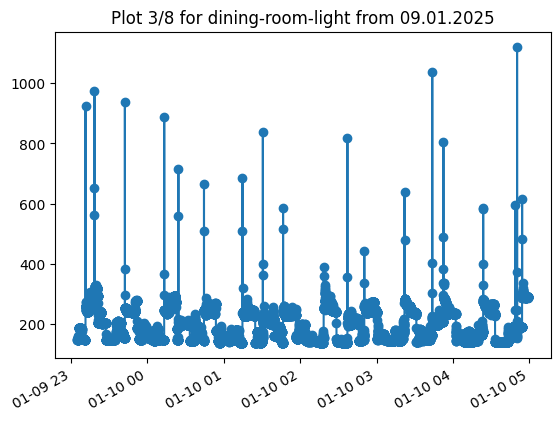

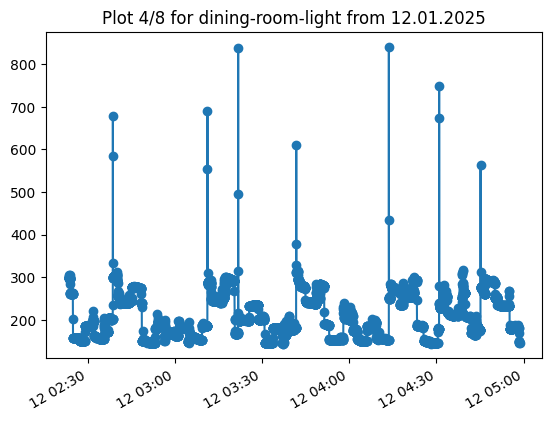

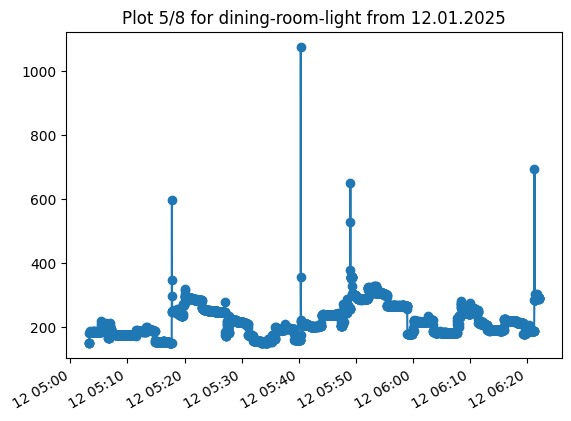

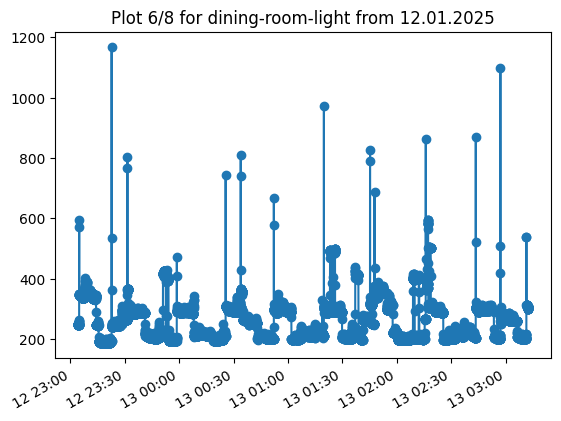

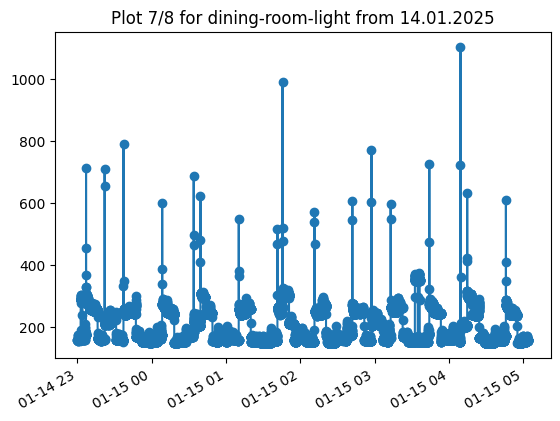

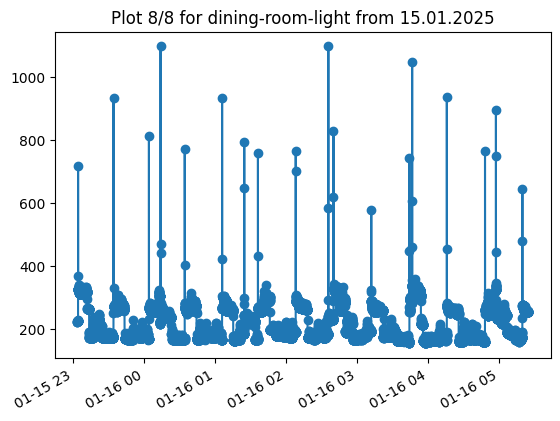

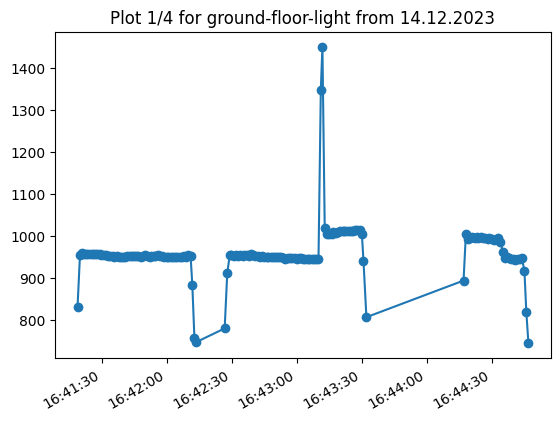

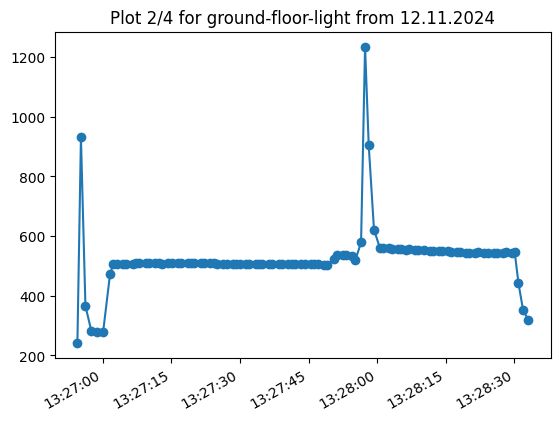

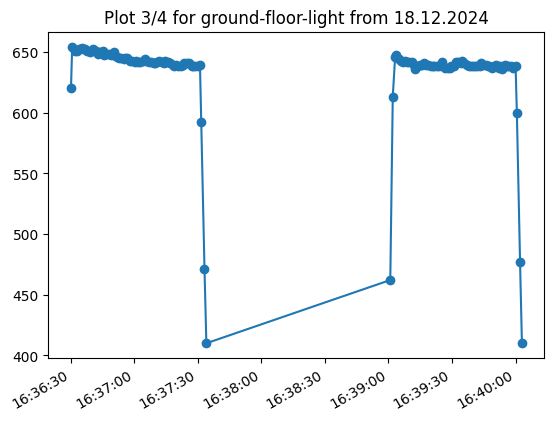

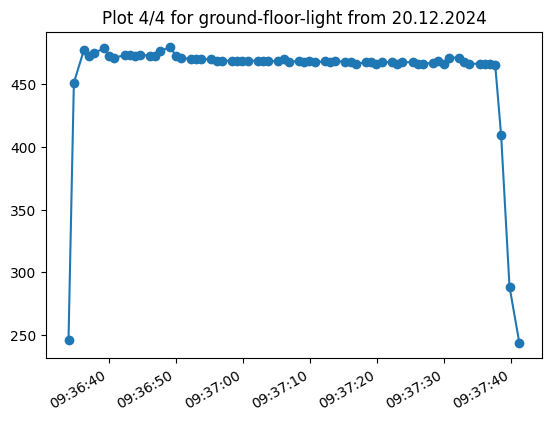

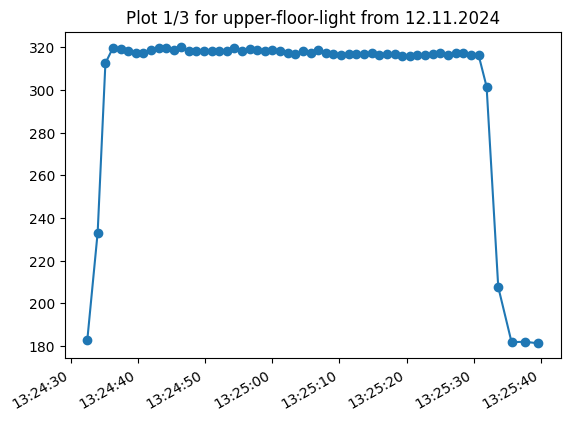

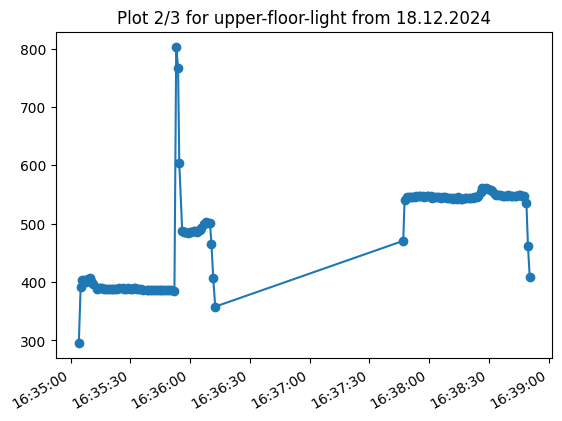

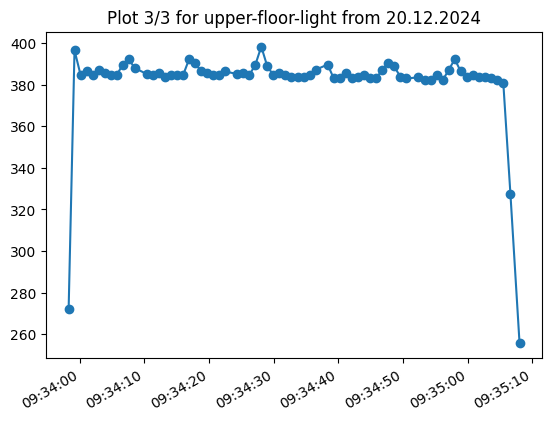

In [4]:
#read the calssified events from the mysql database
dh.read_events_from_db()

#print timeserie of the events
dh.print_events()

In [12]:
dh.device_list[1]['minpow'] = 900
dh.device_list[2]['minpow'] = 0
dh.device_list[4]['minpow'] = 0
dh.device_list[8]['minpow'] = 0
dh.device_list[16]['minpow'] = 0
dh.device_list[32]['minpow'] = 0
dh.device_list[128]['minpow'] = 0
dh.filter_events_by_minpow()

In [ ]:
dh.print_events(128)

In [ ]:
x = pd.to_datetime(dh.event_list[32][0]['timestamp'], utc=True, unit='ms')
y = np.array(dh.event_list[32][0]['value']).astype(float)


x = x[0:240]
y = y[0:240]

f = plt.figure()
a = f.add_subplot()
a.plot(x, y, marker = 'o')

In [ ]:
for i in range(len(dh.event_list[32])):
    print(f"Varianz von Ofen-Event= {np.var(dh.event_list[32][i]['value'])}")        

In [ ]:
test_xx = { 'timestamp' : np.array([]), 'value' : np.array([]), 'device' : np.array([]) }
for key in dh.device_list.keys():
    for i in range(len(dh.event_list[key])):
        test_xx['timestamp'] = np.append(test_xx['timestamp'], dh.event_list[key][i]['timestamp'])
        test_xx['value'] = np.append(test_xx['value'], dh.event_list[key][i]['value'])
        test_xx['device'] = np.append(test_xx['device'], dh.event_list[key][i]['device'])
print(len(test_xx['value']))

In [ ]:
test_x = { 'timestamp' : np.array([]), 'value' : np.array([]), 'device' : np.array([]) }
valid_devices = {1,2,4,8,16,32,64,128}

for i in range(len(test_xx['value'])):
    if test_xx['device'][i] in valid_devices:
        test_x['timestamp'] = np.append(test_x['timestamp'], test_xx['timestamp'][i])
        test_x['value'] = np.append(test_x['value'], test_xx['value'][i])
        test_x['device'] = np.append(test_x['device'], test_xx['device'][i])
print(len(test_x['value']))

In [ ]:
#Programm zur Erkennung von kitchen-light
y = np.zeros(len(test_x['value']))
kitchen = 128
start_kitchen = False
for i in range(len(test_x['value']) - 1):  
    if test_x['value'][i+1] - test_x['value'][i] > 280 and test_x['value'][i+1] - test_x['value'][i] < 310:
        y[i+3] = kitchen
        start_kitchen = True
    if test_x['value'][i+1] - test_x['value'][i] < -280 and test_x['value'][i+1] - test_x['value'][i] > -310:
        y[i] = kitchen
        start_kitchen = False
    if start_kitchen == True:
        y[i] = kitchen

In [ ]:
#Programm zur Erkennung von espresso-machine
#y = np.zeros(len(test_x['value']))
espresso = 1
start_espresso = False
for i in range(len(test_x['value']) - 3):
    if test_x['value'][i+3] - test_x['value'][i] > 950 and test_x['value'][i+3] - test_x['value'][i] < 1050:
        y[i+3]= espresso
        start_espresso = True
    if test_x['value'][i+3]- test_x['value'][i] < -950 and test_x['value'][i+3] - test_x['value'][i] > -1050:
        y[i] = espresso
        start_espresso = False
    if start_espresso == True:
        y[i] = espresso

In [ ]:
#Programm zur Erkennung von washing-machine
#y = np.zeros(len(test_x['value']))
washing = 2
start_washing = False
for i in range(len(test_x['value']) - 150):
    if test_x['value'][i+150] - test_x['value'][i] > 2150 and test_x['value'][i+150] - test_x['value'][i] < 2300:
        y[i+150] = washing
        start_washing = True
        start_i = i
    if start_washing == True and i - start_i >= 7200:
        start_washing = False
    if start_washing == True:
        y[i] = washing

In [ ]:
#Programm zur Erkennung von microwave
#y = np.zeros(len(test_x['value']))
microwave = 64
start_microwave = False
for i in range(len(test_x['value']) - 3):
    if test_x['value'][i+3] - test_x['value'][i] > 1150 and test_x['value'][i+3] - test_x['value'][i] < 1250:
        y[i+3]= microwave
        start_microwave = True
    if test_x['value'][i+3]- test_x['value'][i] < -1150 and test_x['value'][i+3] - test_x['value'][i] > -1250:
        y[i] = microwave
        start_microwave = False
    if start_microwave == True:
        y[i] = microwave

In [ ]:
#Programm zur Erkennung von induction-cooker
#y = np.zeros(len(test_x['value']))
induction = 8
start_induction = False
for i in range(len(test_x['value']) - 180):
    if np.var(test_x['value'][i:i+180]) > 361980 and np.var(test_x['value'][i:i+180]) < 1836900:
        y[i:i+180] = induction
        start_induction = True
    if np.var(test_x['value'][i:i+180]) < 361980 or np.var(test_x['value'][i:i+180]) > 1836900:
        start_induction = False
    if start_induction == True:
        y[i] = induction

In [ ]:
#Programm zur Erkennung von oven
#y = np.zeros(len(test_x['value']))
oven = 32
start_oven = False
for i in range(len(test_x['value']) - 150):
    if np.var(test_x['value'][i:i+150]) > 427160 and np.var(test_x['value'][i:i+150]) < 1322000:
        y[i:i+150] = oven
        start_oven = True
    if np.var(test_x['value'][i:i+150]) < 427160 or np.var(test_x['value'][i:i+150]) > 1322000:
        start_oven = False
    if start_oven == True:
        y[i] = oven

In [ ]:
#Programm zur Erkennung von dish-washer
#y = np.zeros(len(test_x['value']))
dish = 4
start_dish = False
for i in range(len(test_x['value'])-6):
    if test_x['value'][i+6] - test_x['value'][i] > 2200 and test_x['value'][i+6] - test_x['value'][i] < 2300:
        y[i+6] = dish
        start_dish = True
        start_i = i
    if start_dish == True and i - start_i >= 6300:
        start_dish = False
    if start_dish == True:
        y[i] = dish

In [ ]:
#Ergebnis vergleichen
correct = 0
total = len(test_x['value'])
for i in range(total):
    if test_x['device'][i] == y[i]:
        correct = correct + 1

print(f"Die Erfolgsquote beträgt {correct/total*100}%, insgesamt wurden {correct} Messpunkte von {total} korrekt zugeordnet.")

In [ ]:
#Ergebnis richtig vergleichen
correct = 0
total = len(test_x['value'])
for i in range(total):
    if test_x['device'][i] == 1 and y[i] == 1:
        correct = correct + 1

print(f"Die Erfolgsquote beträgt {correct/total*100}%, insgesamt wurden {correct} Messpunkte von {total} korrekt zugeordnet.")

In [ ]:
dh.compare_algo_results(test_x, y)

In [ ]:
#+--------------------+-------+---------+-------+---------+
#|        device name | total | correct | wrong | percent |
#+--------------------+-------+---------+-------+---------+
#|   espresso-machine | 62438 |   15024 | 47414 |     24% |
#|    washing-machine | 19957 |    1767 | 18190 |     39% |
#|        dish-washer | 42685 |   23283 | 19428 |     54% |
#|   induction-cooker |  2083 |     130 |  1953 |      6% |
#|  irrigation-system | 24942 |       0 | 24942 |      0% |
#|               oven | 83577 |   16703 | 66874 |     20% |
#|          microwave |   305 |     245 |    60 |     80% |
#|      kitchen-light |   880 |       0 |   880 |      0% |
#|  living-room-light |     0 |       0 |     0 |         |
#|  dining-room-light |     0 |       0 |     0 |         |
#| ground-floor-light |     0 |       0 |     0 |         |
#|  upper-floor-light |     0 |       0 |     0 |         |
#+--------------------+-------+---------+-------+---------+

In [33]:
#xx, yy = dh.generate_training_data_from_db(window_length)
train_x, train_y, test_x, test_y = dh.generate_training_data_from_events(window_length, event_ratio) #fk: aufteilen der Daten

train_x (batch num, window length): (4552, 43)
train_y (batch num, device num): (4552, 12)
test_x  (batch num, window length): (2775, 43)
test_y  (batch num, device num): (2775, 12)


In [34]:
import keras
input_layer = keras.layers.Input(shape=(train_x.shape[1],1))

conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)

conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.ReLU()(conv3)

gap = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(train_y.shape[1], activation="softmax")(gap)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)


In [35]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 43, 1)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 43, 64)            256       
                                                                 
 batch_normalization_12 (Bat  (None, 43, 64)           256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 43, 64)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 43, 64)            12352     
                                                                 
 batch_normalization_13 (Bat  (None, 43, 64)           256       
 chNormalization)                                          

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=200, verbose=2)
]

In [37]:
# train the model
history = model.fit(
            x=train_x,
            y=train_y,
            batch_size=train_x[0].size,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            verbose=0)


Epoch 201: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


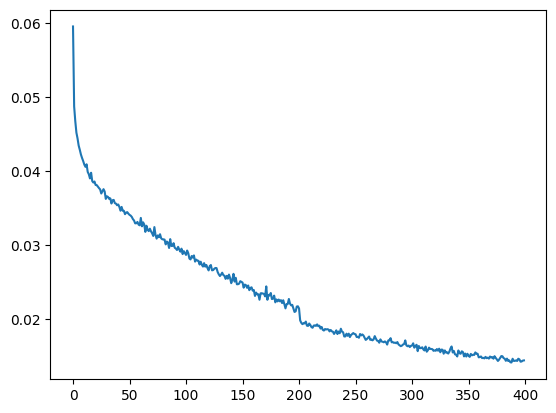

In [38]:
plt.plot(history.history['loss'])


In [39]:
#Prediction with neural network
model = keras.models.load_model("best_model.keras")
predict_y = model.predict(test_x)
    
dh.compare_with_testdata(predict_y, test_x, test_y)

87/87 [==============================] - 1s 5ms/step
+--------------------+-------+---------+-------+---------+
|        device name | total | correct | wrong | percent |
+--------------------+-------+---------+-------+---------+
|   espresso-machine |   183 |       0 |   183 |      0% |
|    washing-machine |   724 |      16 |   708 |      2% |
|        dish-washer |   438 |      23 |   415 |      5% |
|   induction-cooker |    25 |       0 |    25 |      0% |
|  irrigation-system |   458 |     440 |    18 |     96% |
|               oven |   399 |       0 |   399 |      0% |
|          microwave |     5 |       0 |     5 |      0% |
|      kitchen-light |     3 |       0 |     3 |      0% |
|  living-room-light |     0 |       0 |     0 |         |
|  dining-room-light |   539 |       0 |   539 |      0% |
| ground-floor-light |     1 |       0 |     1 |      0% |
|  upper-floor-light |     0 |       0 |     0 |         |
+--------------------+-------+---------+-------+---------+


In [ ]:
#+--------------------+-------+---------+-------+---------+
#|        device name | total | correct | wrong | percent |
#+--------------------+-------+---------+-------+---------+
#|   espresso-machine |   604 |     457 |   147 |     76% |
#|    washing-machine |   159 |      74 |    85 |     47% |
#|        dish-washer |   259 |      30 |   229 |     12% |
#|   induction-cooker |    13 |       0 |    13 |      0% |
#|  irrigation-system |   179 |       2 |   177 |      1% |
#|               oven |   303 |      17 |   286 |      6% |
#|          microwave |     0 |       0 |     0 |         |
#|      kitchen-light |     3 |       0 |     3 |      0% |
#|  living-room-light |     0 |       0 |     0 |         |
#|  dining-room-light |     0 |       0 |     0 |         |
#| ground-floor-light |     1 |       0 |     1 |      0% |
#|  upper-floor-light |     0 |       0 |     0 |         |
#+--------------------+-------+---------+-------+---------+